# 趋势跟踪策略

## 常见趋势指标的回测

注意事项：
- 首先，对依赖的交易信号进行历史回测是投资中最重要的环节，没有之一。历史回测相当于对一种投资想法进行高强度的验证。通过分析回测结果，可以在使用这些交易信号进行实盘投资之前，对它们各自的投资效果和细微差异有客观的了解，达到“去伪存真”的目的。

- 在做回测时，要避免引入未来数据。在每一个历史时点上生成当时的交易信号时，一定要屏蔽掉那个时点之后的数据。



In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# %run ./shared/trend_strategy.py
import sys

sys.path.append('./shared/')

from shared.trend_strategy import get_widgets, get_widgets_for_memontun,get_widgets_for_dual_mv, get_widgets_for_bolling_band,\
    memontun,  mv_cross, bolling_band, load_hist_data, backtest_result, cal_period_perf_indicator


加载回测数据

In [3]:
ui, datePickers, symbols = get_widgets()
ui

In [4]:
start_date = datePickers[0].value
end_date = datePickers[1].value
symbol_id = symbols[0].value
is_fund = symbols[1].value

print(f'loading {symbol_id} between {start_date} and {end_date}')
folders = [
    '../res/small',
    '../res/large',
    '../res/div',
    '../res/specialization',
]
for f in folders:
    index_data = load_hist_data(symbol_id,
                                col_mappings={'nav': symbol_id} if is_fund else {'close': symbol_id},
                                folder=f)
    if index_data is not None:
        break

# index_data

loading 000905 between 2020-01-01 and 2022-12-31


### 近期涨幅的回测

回看天数 N=20，根据回看期上的涨幅决定交易方向，看多阈值 long_threshold=0.05，看空阈值 short_threshold=-0.05。
选取参数后，在沪深 300 指数上进行回测。因为普通投资者不太容易做空沪深 300 指数，所以回测中仓位的规则是：当指标看多时满仓，当指标看空时空仓，其它时间半仓。


设置参数

In [5]:
memontun_ui, memontun_sliders = get_widgets_for_memontun()
memontun_ui

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
asset   0.02996  0.209771  0.142822 -0.315704  0.094898  0.092866
stgy   0.033059   0.11891  0.278017 -0.160118  0.206467  0.102788


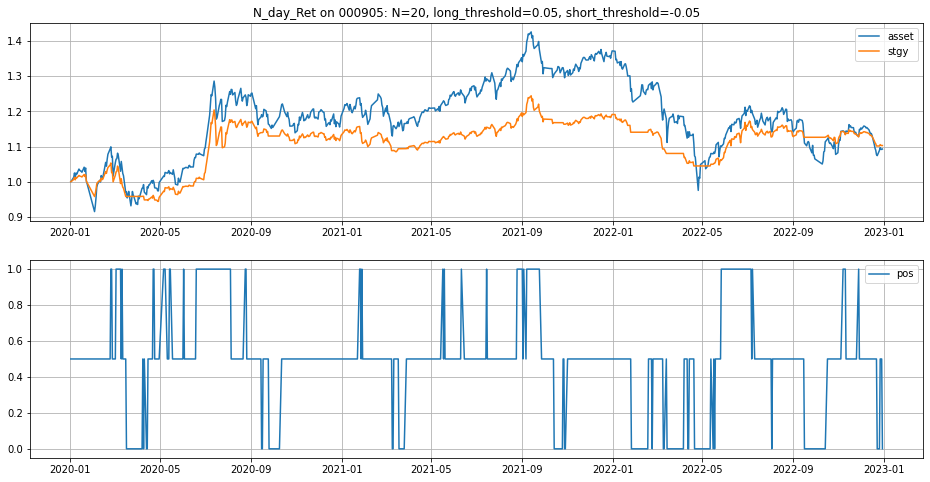

In [6]:
N = memontun_sliders[0].value
long_threshold = memontun_sliders[1].value
short_threshold = memontun_sliders[2].value
# print(f'backtest params: {N} days, long in {long_threshold}, short in {short_threshold}')

df = index_data.loc[start_date:end_date, [symbol_id]]
memontun(df, symbol_id, N, long_threshold, short_threshold)
backtest_result(df,
                title='N_day_Ret on %s: N=%d, long_threshold=%.2f, short_threshold=%.2f' %
                (symbol_id, N, long_threshold, short_threshold))


In [7]:
df.loc[:,['asset','stgy', 'pos']]

,asset,stgy,pos
2020-01-02,1.000000,1.000000,0.5
2020-01-03,1.002702,1.001351,0.5
2020-01-06,1.012804,1.006395,0.5
2020-01-07,1.024915,1.012413,0.5
2020-01-08,1.010745,1.005414,0.5
...,...,...,...
2022-12-26,1.088913,1.101447,0.0
2022-12-27,1.096814,1.105443,0.5
2022-12-28,1.092424,1.103231,0.5
2022-12-29,1.091548,1.102788,0.5


### 双均线系统的回测

短均线回看天数 N1=10，长均线回看天数 N2=60，根据短均线与长均线的比值决定交易方向，看多阈值 1.05，看空阈值 0.95。
选取参数后，在沪深 300 指数上进行回测，决定仓位的规则：当指标看多时满仓，当指标看空时空仓，其他时间半仓。

结果：
显著改善了对沪深 300 的长期投资效果。而且它的好处在于，仓位调整的频率比近期涨幅指标要低很多，大致平均每两个月才调整一次，个人投资者可以比较轻松地实施。


In [8]:
dual_mv_ui, dual_mv_sliders = get_widgets_for_dual_mv()
dual_mv_ui

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
asset   0.02996  0.209771  0.142822 -0.315704  0.094898  0.092866
stgy   0.003041   0.11273   0.02698  -0.16976  0.017916  0.009178


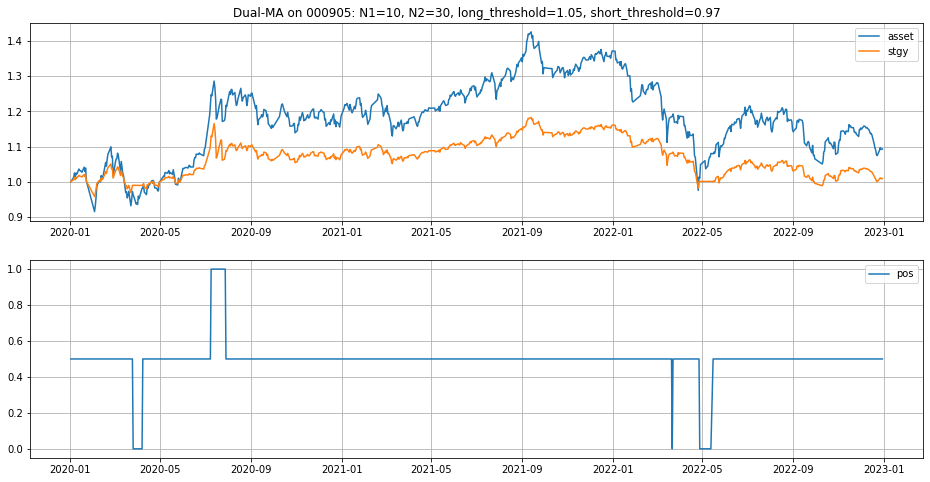

In [9]:
N1 = dual_mv_sliders[0].value
N2 = dual_mv_sliders[1].value
long_threshold = dual_mv_sliders[2].value
short_threshold = dual_mv_sliders[3].value

df = index_data.loc[start_date:end_date, [symbol_id]]

mv_cross(df, symbol_id, N1, N2)
backtest_result(df,
                title='Dual-MA on %s: N1=%d, N2=%d, long_threshold=%.2f, short_threshold=%.2f' %
                (symbol_id, N1, N2, long_threshold, short_threshold))

### 布林带的回测

选取的参数是回看天数 N=20，同样在沪深 300 指数上进行回测，决定仓位的规则还是一样的：当指标看多时满仓，当指标看空时空仓，其他时间半仓。


典型的趋势跟踪策略的特点是“半年不开张，开张吃半年”。

建议个人投资者慎入“高度内卷”的短线趋势策略赛道，重点关注中长期趋势跟踪策略。

In [10]:
band_ui, band_sliders = get_widgets_for_bolling_band()
band_ui

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
asset   0.02996  0.209771  0.142822 -0.315704  0.094898  0.092866
stgy   0.015425  0.101176  0.152456 -0.150088  0.102772  0.047124


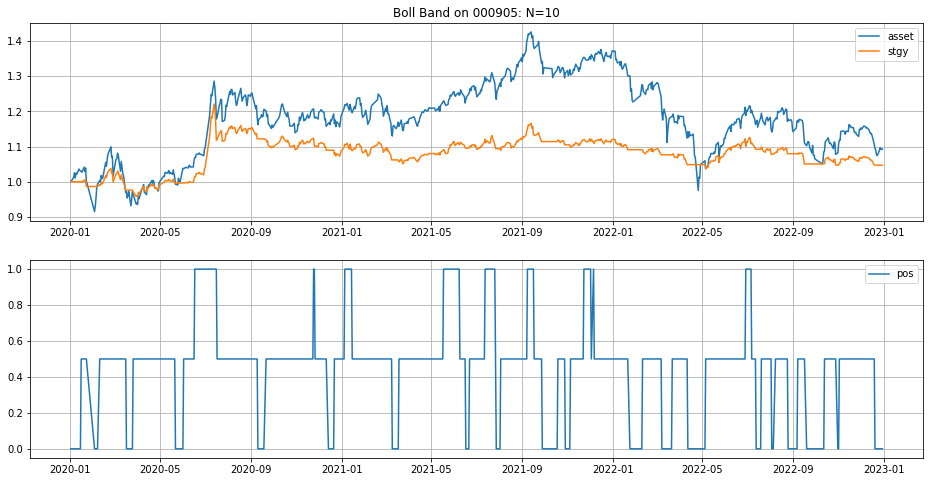

In [11]:
N = band_sliders[0].value

df = index_data.loc[start_date:end_date, [symbol_id]]
bolling_band(df, symbol_id, N)

backtest_result(df, title='Boll Band on %s: N=%d' % (symbol_id, N))

可做空

          AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
000905   0.02996  0.209771  0.142822 -0.315704  0.094898  0.092866
stgy   -0.012311  0.113891 -0.108092 -0.190086 -0.064764 -0.036578


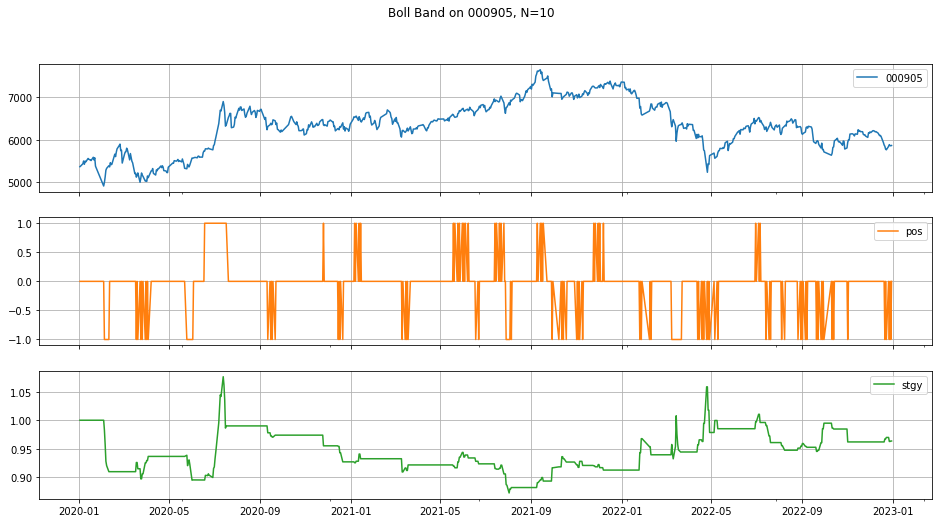

In [12]:
df = index_data.loc[start_date:end_date, [symbol_id]]

df['ret'] = df[symbol_id].pct_change()
df['MA'] = df[symbol_id].rolling(window=N).mean()
df['std'] = df[symbol_id].rolling(window=N).std()
df['up'] = df['MA'] + 2 * df['std']
df['down'] = df['MA'] - 2 * df['std']

df['pos'] = 0
for i in range(2, len(df)):
    t = df.index[i]
    t0 = df.index[i - 2]
    if df.loc[t0, symbol_id] > df.loc[t0, 'up']:
        df.loc[t, 'pos'] = 1
    elif df.loc[t0, symbol_id] < df.loc[t0, 'down']:
        df.loc[t, 'pos'] = -1
    elif df.loc[t0, 'pos'] == 1 and df.loc[t0, symbol_id] < df.loc[t0, 'MA']:
        df.loc[t, 'pos'] = 0
    elif df.loc[t0, 'pos'] == -1 and df.loc[t0, symbol_id] > df.loc[t0, 'MA']:
        df.loc[t, 'pos'] = 0
    else:
        df.loc[t, 'pos'] = df.loc[t0, 'pos']

df['stgy_ret'] = df['ret'] * df['pos']
df['stgy'] = (1 + df['stgy_ret']).cumprod().fillna(1)

df.loc[:, [symbol_id, 'pos', 'stgy']].plot(figsize=(16, 8),
                                          subplots=True,
                                          grid=True,
                                          title='Boll Band on %s, N=%d' % (symbol_id, N))

value_df = df.loc[:, [symbol_id, 'stgy']]
res = cal_period_perf_indicator(value_df)
res['TotalRet'] = value_df.iloc[-1] / value_df.iloc[0] - 1
print(res)